In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [4]:
columns = ['year', 'month', 'day', 'decimal date', 'molfrac', 'days', '1 yr ago', '10 yrs ago', 'since 1800']
df=pd.read_csv('co2_weekly_mlo.txt',sep="\s+",comment="#",names=columns,na_values=-999.99)

In [5]:
df.set_index('decimal date',inplace=True)

In [6]:
df

,year,month,day,molfrac,days,1 yr ago,10 yrs ago,since 1800
decimal date,,,,,,,,
1974.3795,1974,5,19,333.37,5,NaN,NaN,50.40
1974.3986,1974,5,26,332.95,6,NaN,NaN,50.06
1974.4178,1974,6,2,332.35,5,NaN,NaN,49.60
1974.4370,1974,6,9,332.20,7,NaN,NaN,49.65
1974.4562,1974,6,16,332.37,7,NaN,NaN,50.06
...,...,...,...,...,...,...,...,...
2025.7986,2025,10,19,425.20,7,422.17,398.65,148.32
2025.8178,2025,10,26,425.26,5,423.14,398.69,148.09
2025.8370,2025,11,2,424.78,2,423.27,399.37,147.29


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2688 entries, 1974.3795 to 2025.8753
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        2688 non-null   int64  
 1   month       2688 non-null   int64  
 2   day         2688 non-null   int64  
 3   molfrac     2669 non-null   float64
 4   days        2688 non-null   int64  
 5   1 yr ago    2618 non-null   float64
 6   10 yrs ago  2148 non-null   float64
 7   since 1800  2669 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 189.0 KB


In [8]:
df['date']=pd.to_datetime(df[['year','month','day']])

In [9]:
df['molfrac'].fillna(method='ffill',inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2688 entries, 1974.3795 to 2025.8753
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year        2688 non-null   int64         
 1   month       2688 non-null   int64         
 2   day         2688 non-null   int64         
 3   molfrac     2688 non-null   float64       
 4   days        2688 non-null   int64         
 5   1 yr ago    2618 non-null   float64       
 6   10 yrs ago  2148 non-null   float64       
 7   since 1800  2669 non-null   float64       
 8   date        2688 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 210.0 KB


Text(0, 0.5, 'co2')

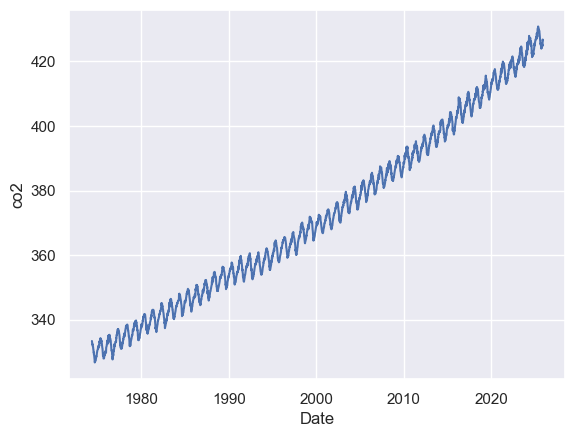

In [11]:
co2=df['molfrac']
plt.plot(co2)
plt.xlabel('Date')
plt.ylabel('co2')

In [12]:
# create indexcer
# create detrnd using poly features
# create seasonal using fourier
# ML model
# ETS model
# Arima model

In [13]:
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.pipeline import Pipeline,FeatureUnion

In [14]:
class Indexer(TransformerMixin,BaseEstimator):# use index only
    def __init__(self):
        """Return indices of dataframe to be used later"""
        pass
    def fit(self,df,y=None):
        return self
    def transform(self,df):
        indices=df.index
        return indices.values.reshape(-1,1)

class FourierFeatures(TransformerMixin,BaseEstimator): #use index only
    def __init__(self,freqs):
        """create features based on sin(2*pi*f*t) and cos(2*pi*f*t)"""
        self.freqs=freqs
    def fit(self,x,y=None):
        return self
    def transform(self,x):
        xt=np.zeros((x.shape[0],2*len(self.freqs)))
        for i,f in enumerate(self.freqs):
            xt[:,2*i]=np.cos(2*np.pi*f*x).reshape(-1)
            xt[:,2*i+1]=np.sin(2*np.pi*f*x).reshape(-1)
        return xt

class ResidualFeatures(TransformerMixin,BaseEstimator):
    def __init__(self,window=100):
        """create features based on window statistics of past noise/residulas"""
        self.window=window
    def fit(self,x,y=None):
        return self
    def transform(self,x):
        df=pd.DataFrame()
        df['resd']=pd.Series(x,index=x.index)
        df['prior']=df['resd'].shift(1)
        df['mean']=df['resd'].rolling(window=self.window).mean()
        df['diff']=df['resd'].diff().rolling(window=self.window).mean()
        df=df.fillna(method='bfill')
        return df

In [15]:
def split_data(cutoff,df,target):
    idx=df.index<cutoff
    df_train=df.loc[idx]
    df_test=df.loc[~idx]
    y_train=df.loc[idx,target]
    y_test=df.loc[~idx,target]
    return df_train,df_test,y_train,y_test

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [17]:
# 

In [164]:
poly=PolynomialFeatures()
fourier=FourierFeatures([1,2])
time=Indexer()
resd_feats=ResidualFeatures(window=100)

union=FeatureUnion([
    ('ploy_feat',poly), # capture trend
    ('fourier',fourier) #capture seasonality
])

pipe_line=Pipeline([
    ('index',time),
    ('union',union),
    ('lr',LinearRegression())
])

pipe_line2=Pipeline([
    ('resd',resd_feats),
    ('lr',LinearRegression())
])

In [165]:
df_train,df_test,y_train,y_test=split_data(cutoff=2010,df=df,target='molfrac')

In [166]:
pipe_line.fit(df_train,y_train)

Pipeline(steps=[('index', Indexer()),
                ('union',
                 FeatureUnion(transformer_list=[('ploy_feat',
                                                 PolynomialFeatures()),
                                                ('fourier',
                                                 FourierFeatures(freqs=[1,
                                                                        2]))])),
                ('lr', LinearRegression())])

In [167]:
# Model Evaluation
pred=pipe_line.predict(df)

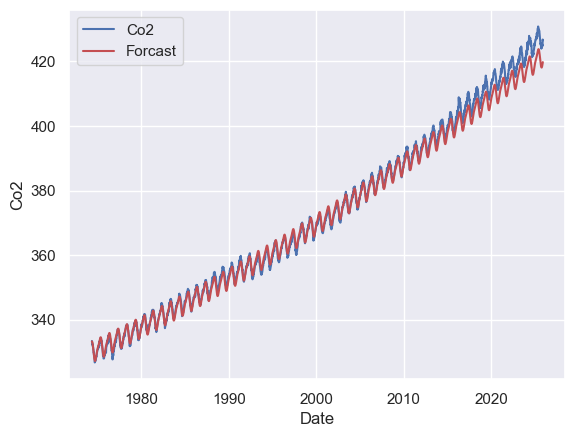

In [168]:
plt.plot(co2)
plt.plot(list(df.index),pred,'-r')
plt.legend(['Co2','Forcast'])
plt.xlabel('Date')
plt.ylabel('Co2')
plt.show()

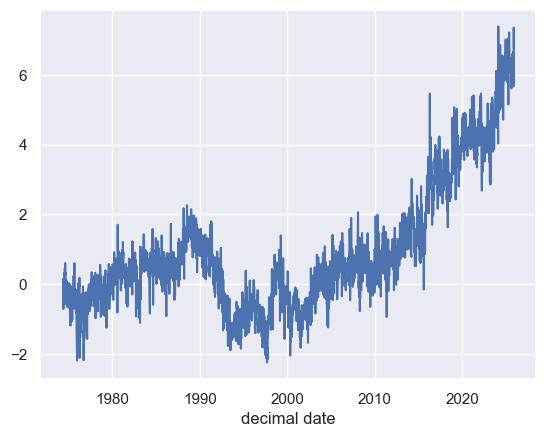

In [169]:
resd=co2-pred
resd.plot()
plt.show()

In [170]:
pipe_line.score(df_test,y_test)

0.9044519855796948

In [171]:
pipe_line.predict(df_train)

array([333.22391209, 333.1802505 , 333.06279529, ..., 387.31590045,
       387.61654431, 387.89242336], shape=(1859,))

In [172]:
# Run pipeline2

In [173]:
from sklearn.base import RegressorMixin

class FullModel(BaseEstimator,RegressorMixin):
    def __init__(self,baseline,residual_model,steps=20):
        """comibne both models to get any number of steps in the future"""
        self.baseline=baseline
        self.residual_model=residual_model
        self.steps=steps
    def fit(self,x,y):
        self.baseline.fit(x,y)
        resd=y-self.baseline.predict(x)
        self.residual_model.fit(resd.iloc[:-self.steps] ,resd.shift(-self.steps).dropna())
        return self

    def predict(self,x):
        y_p=pd.Series(self.baseline.predict(x),index=x.index) #predict main trend
        resd_=x['molfrac'] - y_p
        resd_pred=pd.Series(self.residual_model.predict(resd_),index=x.index) # predict future errors
        resd_pred=resd_pred.shift(self.steps) #very crucial step to forecast future values,
        y_final=y_p+resd_pred

        return y_final   
# Note that : Residuals are based on past information, not future

In [174]:
np.random.seed(42)
n_step=40
full_model=FullModel(pipe_line,pipe_line2,steps=n_step)

In [175]:
full_model.fit(df_train,y_train)

FullModel(baseline=Pipeline(steps=[('index', Indexer()),
                                   ('union',
                                    FeatureUnion(transformer_list=[('ploy_feat',
                                                                    PolynomialFeatures()),
                                                                   ('fourier',
                                                                    FourierFeatures(freqs=[1,
                                                                                           2]))])),
                                   ('lr', LinearRegression())]),
          residual_model=Pipeline(steps=[('resd', ResidualFeatures()),
                                         ('lr', LinearRegression())]),
          steps=40)

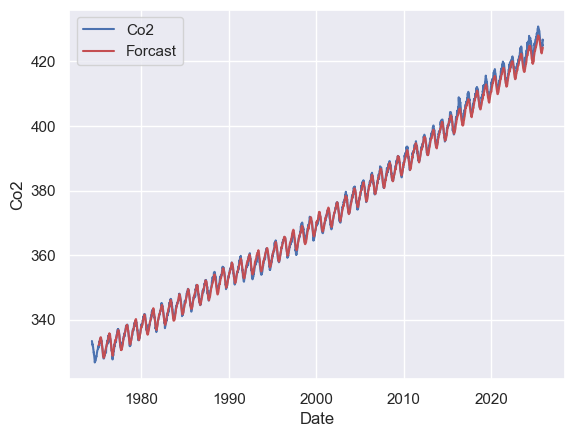

In [30]:
y_pred = full_model.predict(df)
resd = co2 - y_pred
plt.plot(co2)
plt.plot(list(df.index),y_pred,'-r')
plt.legend(['Co2','Forcast'])
plt.xlabel('Date')
plt.ylabel('Co2')
plt.show()

## Validation & Making Predictions

In [31]:
from sklearn.metrics import r2_score
y_pred_test=full_model.predict(df_test)
ind = df_test.index > 2015
print("Test set R^2: {:g}".format(r2_score(y_test.loc[ind], y_pred_test.loc[ind])))

Test set R^2: 0.960774


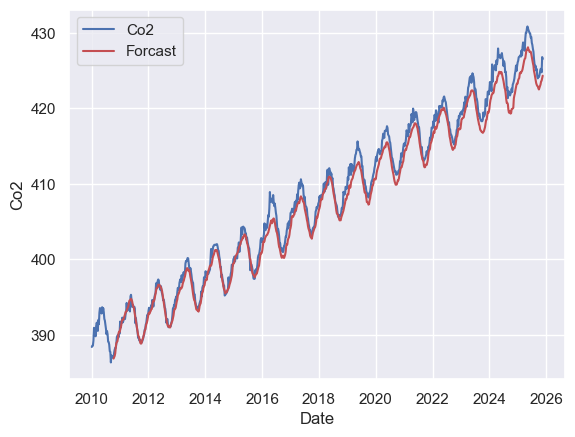

In [32]:
plt.plot(y_test)
plt.plot(list(y_pred_test.index),y_pred_test,'-r')
plt.legend(['Co2','Forcast'])
plt.xlabel('Date')
plt.ylabel('Co2')
plt.show()

In [214]:
step = df_test.index[1] - df_test.index[0]
future_index = [df_test.index[-1] + step * i for i in range(1, n_step+1)]


In [215]:
future_values=y_pred_test.tail(n_step).values

In [216]:
df_future = pd.DataFrame(index=future_index, columns=df_test.columns)

In [217]:
future_forecast = pd.Series(future_values, index=future_index)

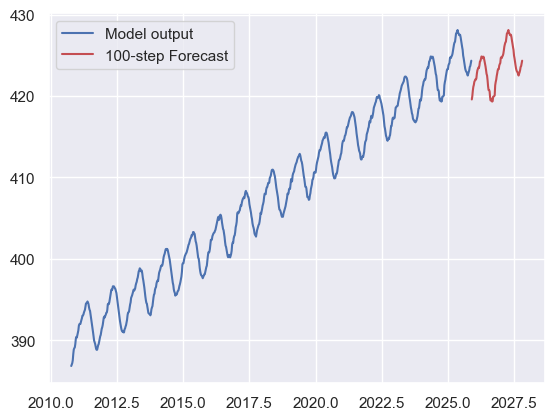

In [218]:
plt.plot(df_test.index, y_pred_test, label="Model output")
plt.plot(future_forecast.index, future_forecast, '-r', label=f"{n_step}-step Forecast")
plt.legend()
plt.show()

# Hybrid ARIMA Model + ML

The ARMA model only works for a stationary process. One method to arrive at a stationary process is to apply a difference transformation, $\Delta y_t = y_t - y_{t-1}$.

the time series of the difference is stationary because it only depends on white Gaussian noise.

In [45]:
from statsmodels.tsa.seasonal import DecomposeResult ,MSTL ,seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
resd_train = y_train - pipe_line.predict(df_train)
arima = SARIMAX(resd_train.values, order=(5, 1, 2), seasonal_order=(1,1,1,52))
arima=arima.fit()

In [185]:
steps = 100
resd_arima_test_pred = arima.forecast(steps)

In [186]:
# To make prediction =predicted_resd+ predicted baseline

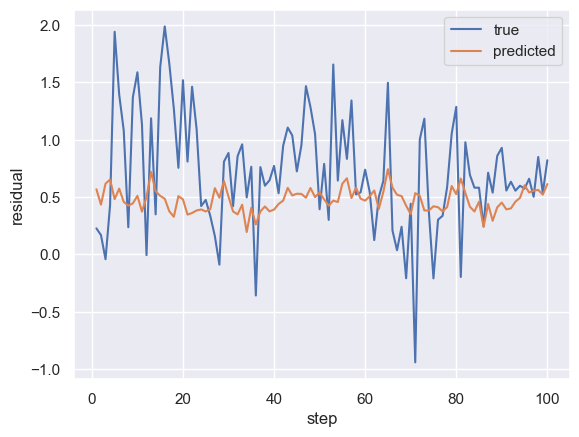

In [187]:
plt.plot(range(1, steps + 1), y_test.iloc[:steps] - pipe_line.predict(df_test.iloc[:steps]))
plt.plot(range(1, steps + 1), resd_arima_test_pred)
plt.xlabel('step')
plt.ylabel('residual')
plt.legend(['true', 'predicted'])
plt.show()

In [188]:
# wnt to show co2 forcasted values for the real values 
# not the residuals 

In [189]:
n_step=100

In [190]:
step = df_test.index[1] - df_test.index[0]
future_index = [df_train.index[-1] + step * i for i in range(1, n_step+1)]
df_future = pd.DataFrame(index=future_index)

In [191]:
# df_future.head()

In [192]:
y_test.iloc[:20].index

Index([2010.0068,  2010.026, 2010.0452, 2010.0644, 2010.0836, 2010.1027,
       2010.1219, 2010.1411, 2010.1603, 2010.1795, 2010.1986, 2010.2178,
        2010.237, 2010.2562, 2010.2753, 2010.2945, 2010.3137, 2010.3329,
       2010.3521, 2010.3712],
      dtype='float64', name='decimal date')

In [193]:
future_pred = pipe_line.predict(y_test.iloc[:n_step])

In [194]:
future_pred = pd.Series(future_pred, index=y_test.iloc[:n_step].index)

In [195]:
final_forecast=future_pred + resd_arima_test_pred

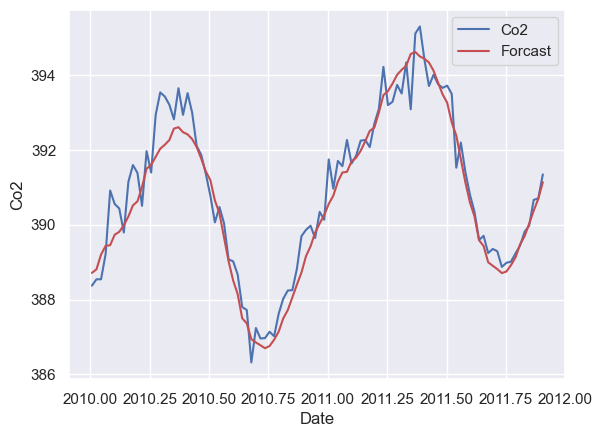

In [196]:
# plt.plot(y_test.iloc[:n_step])
plt.plot(y_test.iloc[:n_step])
plt.plot(final_forecast.iloc[:n_step],'-r')

plt.legend(['Co2','Forcast'])
plt.xlabel('Date')
plt.ylabel('Co2')
plt.show()